In [50]:
import numpy as np
import matplotlib.pyplot as plt

In [51]:
# Initialization of Constants
P_thruster = 1250000 #newtons
P_lift = 1400000 #newtons
P_weight = 500000 #newtons

alpha = 5 #degrees
alpha = alpha * np.pi/180
EC_11 = 148.24e9 #Pascals, AS4 Axial Young's Modulus
EC_22 = 10.07e9 #Pascals, AS4 Transverse Young's Modulus
vC_12 = 0.3 # Major in-plane Poisson's ratio
vC_21 = EC_22*vC_12/EC_11 # Minor in-plane Poisson's ratio
GC_12 = 5.58e9 #Gigapascals, Shear Modulus 

EAl = 69.69e9 #Pascals

R_c = 1.5
R_a = 1.495
R_i = 1.49
L = 20 # meters



In [63]:
# Determining Axial Stiffness, S
def getE(beta):
    beta = beta * np.pi/180 #converting degrees to radians
    
    # Reduced Stiffness Matrix in Local Coordinates
    Q = np.array([[(EC_11)/(1-vC_12*vC_21), (vC_21*EC_11)/(1-vC_12*vC_21), 0], 
                  [(vC_12*EC_22)/(1-vC_12*vC_21), (EC_22)/(1-vC_12*vC_21), 0],
                  [0, 0, GC_12]])

    # Reuter's Matrix
    R = np.array([[1,0,0],[0,1,0],[0,0,2]]) 
    
    # Rotation Matrix
    T = np.array([[np.cos(beta)**2, np.sin(beta)**2, 2*np.sin(beta)*np.cos(beta)],
                 [np.sin(beta)**2, np.cos(beta)**2,-2*np.sin(beta)*np.cos(beta)],
                 [-1*np.sin(beta)*np.cos(beta), np.sin(beta)*np.cos(beta),np.cos(beta)**2 - np.sin(beta)**2]])
    
    # Reduced Stiffness Matrix in Global Coordinates
    Q_bar = np.matmul(np.linalg.inv(T), np.matmul(Q, np.matmul(R, np.matmul(T,np.linalg.inv(R)))))

    S_bar = np.linalg.inv(Q_bar)

    E_axial = 1/S_bar[0,0]
    return E_axial

E_layers = np.array([getE(0), getE(45), getE(-45), getE(90), getE(90), getE(-45), getE(45), getE(0)]) 

# Equations for P1 & P2 (Horizontal and Vertical Resultant Forces)
P1 = P_lift*np.sin(alpha) - P_thruster
P2 = P_lift*np.cos(alpha) - P_weight*np.cos(alpha)

# Calculates Axial Stiffness (S) for each layer and sums them for total S
# iterate from the outer radius in
r = R_c
S = 0
i = 0
numLayers = 8
while i < numLayers:
    S = S + (E_layers[i]) * np.pi * (r**2 - (r - 0.005/8)**2)
    r = r - 0.005/8
    i = i + 1
S = S + np.pi * EAl * (R_a**2 - R_i**2)
print("Value of S for laminate and aluminium is:", S, "N/m")

# Calculating Bending Stiffness
H_33 = 0
r = R_c
i = 0
while i < numLayers: 
    H_33 = H_33 + E_layers[i] * np.pi * (r**4 - (r - 0.005/8)**4)/4
    r = r - 0.005/8
    i = i + 1
H_33 = H_33 + EAl * np.pi * (R_a**4 - R_i**4)/4
print("Value of H_33 is: ", H_33)

# Axial Displacement
x1 = np.linspace(0,20,50)
u1 = (P_lift*np.sin(alpha)*x1 - P_thruster*x1)/S

# Axial Strain
eps1 = (P_lift*np.sin(alpha) - P_thruster)/S

# M3max at x1=0
M3 = -P_weight*np.cos(alpha)*(L-5) + P_lift*np.cos(alpha)*L
print(M3)

# Axial Stress due to Bending in each layer
r = np.arange(1.499375,1.494375,-0.000625)
sigma = np.zeros(len(E_layers))
for i in range(len(sigma)): 
    sigma[i] = (-E_layers[i] * r[i] * M3)/H_33
print(sigma)




Value of S for laminate and aluminium is: 5464167650.135862 N/m
Value of H_33 is:  6102313101.191694
20421991.310880784
[-7.43839560e+08 -7.13435682e+07 -7.13138169e+07 -5.04661183e+07
 -5.04450557e+07 -7.12245631e+07 -7.11948118e+07 -7.41669123e+08]


Text(0, 0.5, 'Bending Moment')

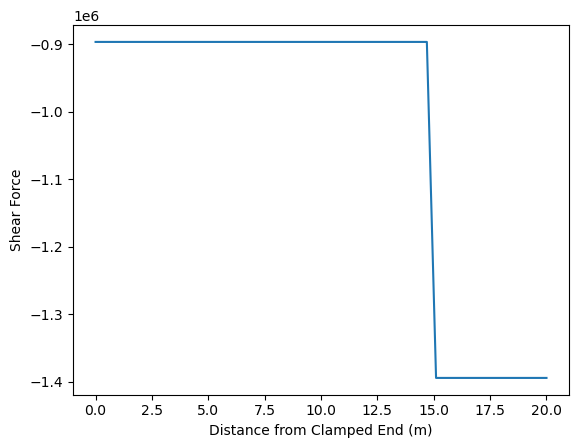

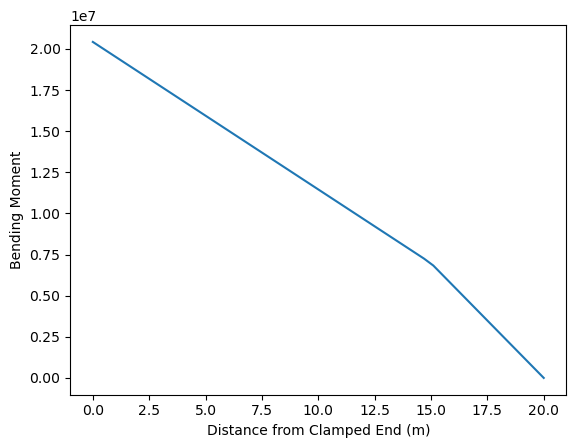

In [77]:
# Shear Diagram
x1 = np.linspace(0,20,50)
y1 = np.piecewise(x1, [x1<=15, x1>15], 
                 [lambda x1:  -P_lift*np.cos(alpha) + P_weight*np.cos(alpha), 
                  lambda x1: -P_lift*np.cos(alpha)])


# Bending moment diagram 
y2 = np.piecewise(x1, [x1<15, x1>=15],
                 [lambda x1: -P_weight*np.cos(alpha)*(L-5-x1) + P_lift*np.cos(alpha)*(L-x1), 
                  lambda x1: P_lift*np.cos(alpha)*(L-x1)])

plt.figure()
plt.plot(x1,y1)
#plt.title("Shear Moment Diagram")
plt.xlabel("Distance from Clamped End (m)")
plt.ylabel("Shear Force")

plt.figure()
plt.plot(x1,y2)
#plt.title("Bending Moment Diagram")
plt.xlabel("Distance from Clamped End (m)")
plt.ylabel("Bending Moment")